# **[Week 13] Fine-Tuning Foundation Models (FMs)**


## **Objective**

1. Understand a vision-language foundation model (**CLIP**).
2. Perform prompt tuning on **CLIP** using Pytorch.
3. Evaluate the trained CLIP and compare its performance with the original CLIP.
3. Add a regularization loss to preserve the generalization capability of FMs.


### **Basic Concepts of the CLIP Network**
CLIP (Contrastive Language-Image Pretraining) [ICML'21] is a vision-language foundation model that is trained on a large-scale dataset of image-text pairs using contrastive learning. This allows CLIP to perform zero-shot classification, image retrieval, and text-to-image matching without fine-tuning on specific datasets.

#### **Classification in CLIP**

In CLIP, images are processed through an image encoder to obtain corresponding image features, while texts are processed through a text encoder to obtain corresponding text features. For image classification, text features are extracted using a template, such as "a photo of a {class}", where {class} is the category to be classified. For example, for the class dog, the corresponding text feature is extracted from "a photo of a dog." Text features are obtained for all classes, and their cosine similarities with the given image feature are computed. These similarity scores serve as the logit vector for classification.

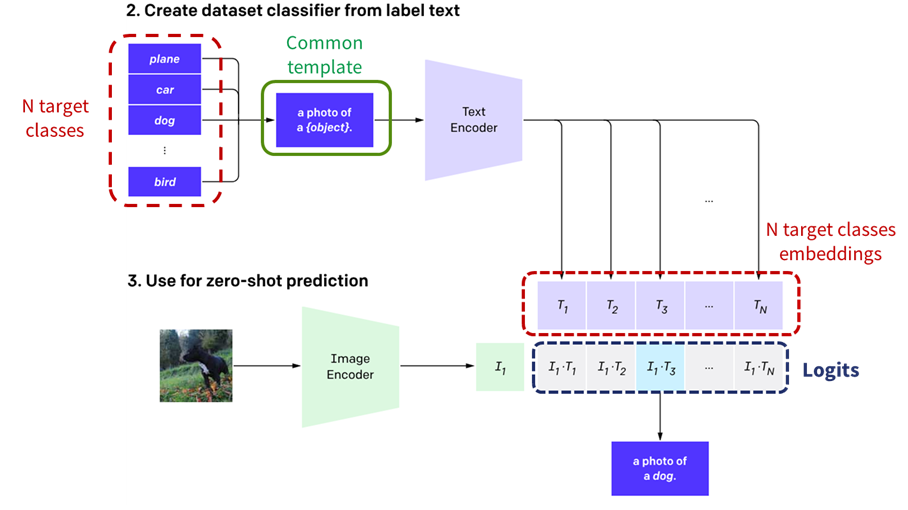

#### **Prompt tuning in CLIP [IJCV'22]**

Prompt tuning is a parameter-efficient fine-tuning method that enables the effective adaptation of foundation models to specific domains. Instead of modifying the original model’s parameters, it introduces learnable prompts into the text input space and optimizes them during training. The figure below illustrates the prompt tuning method in CLIP, where learnable prompts are prepended to class names and passed through the text encoder.

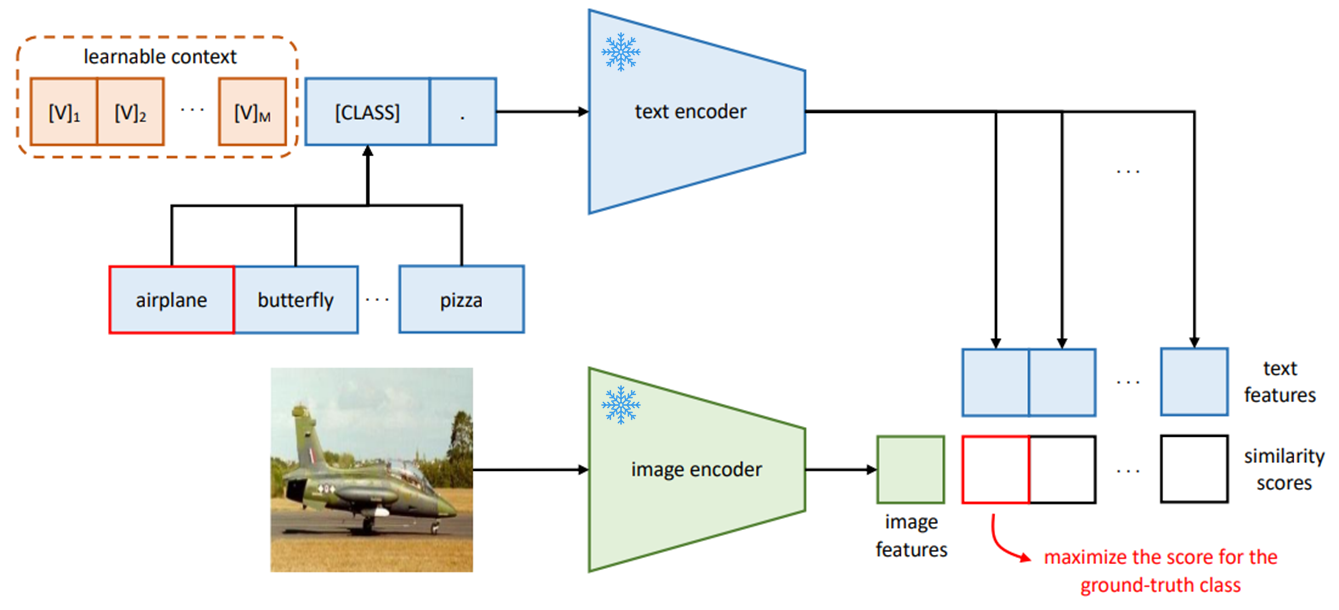

### **Implementation of CLIP using Pytorch**

Load necessary packages and the **CLIP** network.


In [ ]:
# It takes quite a long time, so run this cell beforehand.
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install torchvision

### **Task 1) Perform prompt tuning on CLIP using Pytorch.**

- Load the CLIP model and prepare a training dataset.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import clip
from torch.utils.data import DataLoader, Subset
import numpy as np
import random

# Fix the seed for reproducibility
random.seed(100)
torch.manual_seed(100)

# Device setting
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the CLIP network (ViT-B/32)
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()  # Freeze the model parameters.
for p in model.parameters():
    p.requires_grad = False

# Load the training dataset
train_transform = preprocess  # Image preprocessing
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)

- Split the training dataset into base and new classes. For the CIFAR-100 dataset, classes 0 to 49 are used as base classes for training, while classes  50 to 99 classes are used as new classes. The optimized model is evaluated on both the base and new classes.

In [ ]:
# Divide all classes (0 ~ 99) into base (0 ~ 49) and new (50 ~ 99) classes.
# Randomly sample 16 instances from each base class for training.
base_train_indices = []
for c in range(50):
    indices = [i for i, t in enumerate(train_dataset.targets) if t == c]
    selected = random.sample(indices, 16)  # Select random samples for each class
    base_train_indices.extend(selected)
base_train_dataset = Subset(train_dataset, base_train_indices)

# Make a trainloader for the base classes
train_loader = DataLoader(base_train_dataset, batch_size=4, shuffle=True, num_workers=2)

# Load test datasets
test_transform = preprocess
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
# Test dataset for the base classes: label 0 ~ 49
base_test_indices = [i for i, t in enumerate(test_dataset.targets) if t in list(range(50))]
# Test dataset for the new classes: label 50 ~ 99
new_test_indices  = [i for i, t in enumerate(test_dataset.targets) if t in list(range(50,100))]
base_test_dataset = Subset(test_dataset, base_test_indices)
new_test_dataset  = Subset(test_dataset, new_test_indices)
base_test_loader = DataLoader(base_test_dataset, batch_size=4, shuffle=False, num_workers=2)
new_test_loader  = DataLoader(new_test_dataset, batch_size=4, shuffle=False, num_workers=2)


#### **Define PromptLearner class.**
- This class inserts learnable prompts into the text input space and extract  features for each class.
- The added prompt length is set to 4 and replaces the phrase "a photo of a" in each text input.
- The prompts are randomly initialized using a Gaussian distribution.
- Each text input (e.g., "a photo of a dog") is first tokenized and then passes through the text encoder.
- The final text feature is extracted from the position of the EOS token (which has the maximum sequence index in the tokenized input).

In [ ]:
class PromptLearner(nn.Module):
    def __init__(self, clip_model, classnames, prompt_length=4, ctx_position=1):

        super().__init__()
        self.clip_model = clip_model
        self.classnames = classnames
        self.n_classes = len(classnames)
        self.prompt_length = prompt_length
        self.ctx_position = ctx_position
        self.original = False

        self.embedding_dim = clip_model.token_embedding.weight.shape[1]
        # Define learnable prompts
        self.ctx = nn.Parameter(torch.empty(prompt_length, self.embedding_dim,
                                             dtype=clip_model.text_projection.dtype))
        # Initialize the prompts using a Gaussian distribution.
        nn.init.normal_(self.ctx, std=0.02)

        # Tokenize for each class
        self.tokenized_classnames = clip.tokenize([f"a photo of a {c}" for c in classnames]).to(device)  # shape: (n_classes, token_length)

    def forward(self):

        dtype = self.clip_model.text_projection.dtype
        # Pass through the embedding layer
        token_embeddings = self.clip_model.token_embedding(self.tokenized_classnames).to(dtype)

        # Insert learnable prompts into text embeddings
        # Note that the first token is the start token; therefore, the prompts are inserted starting from the second token.
        token_embeddings[:, self.ctx_position:self.ctx_position+self.prompt_length, :] = self.ctx.to(dtype)

        # Positional embedding
        x = token_embeddings + self.clip_model.positional_embedding.to(dtype)

        x = x.permute(1, 0, 2)
        x = self.clip_model.transformer(x)
        x = x.permute(1, 0, 2)
        x = self.clip_model.ln_final(x)

        # Extract the final text feature from the position of the EOS token.
        eos_ind = ((self.tokenized_classnames).argmax(dim=-1))
        x = x[torch.arange(x.shape[0]), eos_ind, :]

        text_features = x @ self.clip_model.text_projection.to(dtype)
        return text_features  # shape: (n_classes, feature_dim)

# Class names of the CIFAR100 dataset
cifar100_classes = [
    "apple", "aquarium_fish", "baby", "bear", "beaver", "bed", "bee", "beetle", "bicycle", "bottle",
    "bowl", "boy", "bridge", "bus", "butterfly", "camel", "can", "castle", "caterpillar", "cattle",
    "chair", "chimpanzee", "clock", "cloud", "cockroach", "couch", "crab", "crocodile", "cup", "dinosaur",
    "dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster", "house", "kangaroo", "keyboard",
    "lamp", "lawn_mower", "leopard", "lion", "lizard", "lobster", "man", "maple_tree", "motorcycle", "mountain",
    "mouse", "mushroom", "oak_tree", "orange", "orchid", "otter", "palm_tree", "pear", "pickup_truck", "pine_tree", "plain",
    "plate", "poppy", "porcupine", "possum", "rabbit", "raccoon", "ray", "road", "rocket", "rose",
    "sea", "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake", "spider", "squirrel",
    "streetcar", "sunflower", "sweet_pepper", "table", "tank", "telephone", "television", "tiger", "tractor", "train",
    "trout", "tulip", "turtle", "wardrobe", "whale", "willow_tree", "wolf", "woman", "worm"
]
base_classnames = cifar100_classes[:50]  # Class names for the base classes
new_classnames = cifar100_classes[50:]   # Class names for the new classes

# base prompt learner (for training) to extract text features of the base classes
base_prompt_learner = PromptLearner(model, base_classnames, prompt_length=4, ctx_position=1).to(device)
# new prompt learner to extract text features of the new classes
new_prompt_learner = PromptLearner(model, new_classnames, prompt_length=4, ctx_position=1).to(device)
new_prompt_learner.ctx = base_prompt_learner.ctx # The trained prompts are shared


#### **Optimize the prompts during training**

- Extract the image and text features from the image and text encoders and normalize them.
- Using the normalized features, compute the cosine similarity, which serves as the logit vector.
- In CLIP, we consider the logit scale that scales the cosine similarity before applying softmax, improving training stability and performance.

In [ ]:
# Training settings
optimizer = optim.SGD(base_prompt_learner.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
n_epochs = 2 # Epoch
logit_scale = model.logit_scale.exp()  # Scaling parameter

for epoch in range(n_epochs):
    base_prompt_learner.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Extract image features from the image encoder
        with torch.no_grad():
            image_features = model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # Extract text features for the base classes from the text encoder
        text_features = base_prompt_learner()
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Compute the similarity to generate logits for each sample using the inner product
        logits = logit_scale * image_features @ text_features.t() # shape: (B, 50)
        loss = criterion(logits, labels) # Compute the cross entropy loss by comparing the logits and the corresponding labels
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}")


#### **Evaluation and comparison between the prompt tuned CLIP and the original CLIP.**

In [ ]:
# Evaluation of the trained network
@torch.no_grad()
def evaluate_with_prompt(model, prompt_learner, dataloader, label_offset=0):
    prompt_learner.eval()
    correct = 0
    total = 0
    text_features = prompt_learner()
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    scale = model.logit_scale.exp()

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        if label_offset:
            labels = labels - label_offset
        image_features = model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        logits = scale * image_features @ text_features.t()  # (B, n_classes)
        preds = logits.argmax(dim=-1)
        correct += (preds == labels).sum().item()
        total += images.size(0)
    return correct / total

# Evaluation of the original CLIP
@torch.no_grad()
def evaluate_original_clip(model, classnames, dataloader, label_offset=0):
    prompts = [f"a photo of a {c}" for c in classnames]
    tokenized_prompts = clip.tokenize(prompts).to(device)
    with torch.no_grad():
        text_features = model.encode_text(tokenized_prompts)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    scale = model.logit_scale.exp()
    correct = 0
    total = 0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        if label_offset:
            labels = labels - label_offset
        image_features = model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        logits = scale * image_features @ text_features.t()
        preds = logits.argmax(dim=-1)
        correct += (preds == labels).sum().item()
        total += images.size(0)
    return correct / total


# (1) Performance of the prompt tuned CLIP.
base_acc_tuned = evaluate_with_prompt(model, base_prompt_learner, base_test_loader, label_offset=0)
new_acc_tuned  = evaluate_with_prompt(model, new_prompt_learner, new_test_loader, label_offset=50)  # Label offset 50

# (2) Performance of the original CLIP (use the original template "a photo of a {class}")
base_acc_orig = evaluate_original_clip(model, base_classnames, base_test_loader, label_offset=0)
new_acc_orig  = evaluate_original_clip(model, new_classnames, new_test_loader, label_offset=50) # Label offset 50

print("=== Performance Comparison ===")
print(f"Prompt Tuning - Base Accuracy: {base_acc_tuned*100:.2f}%")
print(f"Prompt Tuning - New Accuracy:  {new_acc_tuned*100:.2f}%")
print(f"Original CLIP - Base Accuracy:  {base_acc_orig*100:.2f}%")
print(f"Original CLIP - New Accuracy:   {new_acc_orig*100:.2f}%")

### **Task 2-2) Add a regularization loss to preserve the generalization capability of FMs.**

However, as shown in the results above, the prompt tuned CLIP acheives lower generalization performance (on the new classes) compared to the original CLIP. To prevent this degradation (or even improve generalization) on the new classes, a regularization loss (e.g., L1 loss) can be introduced, as illustrated in the figure below. Specifically, the L-1 loss is computed between the text features of the prompt tuned CLIP and those of the original CLIP to prevent the original model's generalization ability during training.

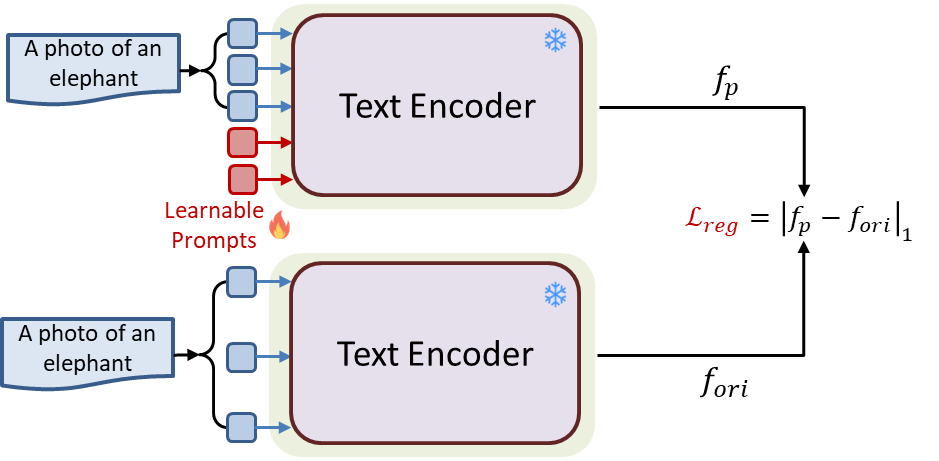

In [ ]:
# Define PromptLearner class.

class PromptLearner(nn.Module):
    def __init__(self, clip_model, classnames, prompt_length=4, ctx_position=1):

        super().__init__()
        self.clip_model = clip_model
        self.classnames = classnames
        self.n_classes = len(classnames)
        self.prompt_length = prompt_length
        self.ctx_position = ctx_position

        self.embedding_dim = clip_model.token_embedding.weight.shape[1]
        self.ctx = nn.Parameter(torch.empty(prompt_length, self.embedding_dim,
                                             dtype=clip_model.text_projection.dtype))
        nn.init.normal_(self.ctx, std=0.02)
        self.tokenized_classnames = clip.tokenize([f"a photo of a {c}" for c in classnames]).to(device)

    def forward(self, original=False):

        dtype = self.clip_model.text_projection.dtype

        token_embeddings = self.clip_model.token_embedding(self.tokenized_classnames).to(dtype)

        # To extract text features of the prompt tuned CLIP or the original CLIP
        if not original:
            token_embeddings[:, self.ctx_position:self.ctx_position+self.prompt_length, :] = self.ctx.to(dtype)

        x = token_embeddings + self.clip_model.positional_embedding.to(dtype)

        x = x.permute(1, 0, 2)
        x = self.clip_model.transformer(x)
        x = x.permute(1, 0, 2)
        x = self.clip_model.ln_final(x)
        eos_ind = ((self.tokenized_classnames).argmax(dim=-1))
        x = x[torch.arange(x.shape[0]), eos_ind, :]

        text_features = x @ self.clip_model.text_projection.to(dtype)
        return text_features  # shape: (n_classes, feature_dim)


base_prompt_learner = PromptLearner(model, base_classnames, prompt_length=4, ctx_position=1).to(device)
new_prompt_learner = PromptLearner(model, new_classnames, prompt_length=4, ctx_position=1).to(device)
new_prompt_learner.ctx = base_prompt_learner.ctx


#### **Optimize the prompts with the L-1 regularization loss**

- In this task, add a regularization loss by computing the L-1 loss beteeen text features of the prompt tuned CLIP and those of the original CLIP to prevent the original model's generalization ability during training.

In [ ]:
optimizer = optim.SGD(base_prompt_learner.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
l_1 = torch.nn.functional.l1_loss
n_epochs = 2
logit_scale = model.logit_scale.exp()

for epoch in range(n_epochs):
    base_prompt_learner.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.no_grad():
            image_features = model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        text_features = base_prompt_learner()
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        ################################################ To Do ###################################################################################
        # Extract the original text feature and compute the L1 loss between the text features of the prompted CLIP and those of the original CLIP.
        # Note: we can get the original text features by using "base_prompt_learner(original=True)"

        l1_loss = ...
        ##########################################################################################################################################

        logits = logit_scale * image_features @ text_features.t()  # shape: (B, 5)
        loss = criterion(logits, labels)
        loss = loss + l1_loss * 200
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}")



base_acc_tuned = evaluate_with_prompt(model, base_prompt_learner, base_test_loader, label_offset=0)
new_acc_tuned  = evaluate_with_prompt(model, new_prompt_learner, new_test_loader, label_offset=50)  # new: 레이블 offset 5

base_acc_orig = evaluate_original_clip(model, base_classnames, base_test_loader, label_offset=0)
new_acc_orig  = evaluate_original_clip(model, new_classnames, new_test_loader, label_offset=50)

print("=== Performance Comparison ===")
print(f"Prompt Tuning - Base Accuracy: {base_acc_tuned*100:.2f}%")
print(f"Prompt Tuning - New Accuracy:  {new_acc_tuned*100:.2f}%")
print(f"Original CLIP - Base Accuracy:  {base_acc_orig*100:.2f}%")
print(f"Original CLIP - New Accuracy:   {new_acc_orig*100:.2f}%")


## **Reference**

- [ICML’21] Radford et al., “Learning Transferable Visual Models From Natural Language Supervision”
- [IJCV’22] Zhou et al., “Learning to Prompt for Vision-Language Models”
